# Measurements with suppression electrode but without extraction electrode

Days were 2020-01-24, 27, and 28


In [1]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

In [2]:
def load_data_for_day_DATABASE(DAY, PATH):
    # reference detectors
    # dose
    # HV

    # read password and user to connect to database
    credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
    user = credentials['username'].values[0]
    pw = credentials['password'].values[0]


    #*******************************
    # GET DATA
    #*******************************

    # connect to DB
    con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

    # get dose
    query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
    data_dose = con.get_from_database(query=query)

    # get HV
    query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
    data_hv = con.get_from_database(query=query)
    data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

    # get pressure
    query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
    data_pressure = con.get_from_database(query=query)

    # get microwave power
    query = "SELECT * FROM microwave_generator_power WHERE DATE(time) = '%(t)s'" % {"t": DAY}
    data_microwave_power_full = con.get_from_database(query=query)

    # get microwave frequency
    query = "SELECT * FROM microwave_generator_frequency WHERE DATE(time) = '%(t)s'" % {"t": DAY}
    data_microwave_frequency_full = con.get_from_database(query=query)

    fig, ax = plt.subplots(figsize=(10,4))
    sns.set()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax, color='darkblue')

    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.set_ylabel('Dose [muSv/hr]')
    ax.set_xlabel(f'Time, {DAY}')
    plt.show()

    fig, ax = plt.subplots(figsize=(10,4))
    sns.set()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.lineplot(x=data_hv.index, y='HV_voltage', data=data_hv, ax=ax, color='darkred')

    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.set_ylabel('HV V [kV]')
    ax.set_xlabel(f'Time, {DAY}')
    plt.show()

    fig, ax = plt.subplots(figsize=(10,4))
    sns.set()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.lineplot(x=data_hv.index, y='HV_current', data=data_hv, ax=ax, color='darkorange')

    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.set_ylabel('HV I [mA] (incl. leakage)')
    ax.set_xlabel(f'Time, {DAY}')
    plt.show()


    fig, ax = plt.subplots(figsize=(10,4))
    sns.set()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.lineplot(x=data_pressure.index, y='pressure_IS_corrected', data=data_pressure, ax=ax, color='darkgreen')

    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.set_ylabel('pressure [mbar]')
    ax.set_xlabel(f'Time, {DAY}')
    ax.set_yscale('log')
    plt.show()

    data_dose.to_csv(f'{PATH}/{DAY}_dose.csv')
    data_hv.to_csv(f'{PATH}/{DAY}_hv.csv')
    data_pressure.to_csv(f'{PATH}/{DAY}_pressure.csv')
    data_microwave_power_full.to_csv(f'{PATH}/{DAY}_microwave_power.csv')
    data_microwave_frequency_full.to_csv(f'{PATH}/{DAY}_microwave_frequency.csv')
    
    
    return data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full

In [3]:
def load_data_for_day_CSV(DAY, PATH):
    data_dose = pd.read_csv(f'{PATH}/{DAY}_dose.csv', index_col=0)
    data_hv = pd.read_csv(f'{PATH}/{DAY}_hv.csv', index_col=0)
    data_pressure = pd.read_csv(f'{PATH}/{DAY}_pressure.csv', index_col=0)
    data_microwave_power_full = pd.read_csv(f'{PATH}/{DAY}_microwave_power.csv', index_col=0)
    data_microwave_frequency_full = pd.read_csv(f'{PATH}/{DAY}_microwave_frequency.csv', index_col=0)

    for df in [data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full]:
        df.index = pd.to_datetime(df.index)
        
        
    return data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full

In [4]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out


In [5]:
dfs = {} # dictionary with the results from each day

## 2020-01-24

In [6]:
DAY = "2020-01-24"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-24.Suppression_without_extraction/'

In [ ]:
# data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full = load_data_for_day_DATABASE(DAY, PATH)

In [7]:
data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full = load_data_for_day_CSV(DAY, PATH)

### Subset of the dataset

In [8]:
time_start = f"{DAY} 13:00:00"
time_end = f"{DAY} 17:30:00"


data_dose = data_dose.loc[time_start:time_end, :]
data_hv = data_hv.loc[time_start:time_end, :]
data_pressure = data_pressure.loc[time_start:time_end, :]
data_microwave_power_full = data_microwave_power_full.loc[time_start:time_end, :]
data_microwave_frequency_full = data_microwave_frequency_full.loc[time_start:time_end, :]


In [9]:
d_hv = resample_30_seconds(data_hv, ['HV_current', 'HV_voltage'], time_start, time_end) 
d_dose = resample_30_seconds(data_dose, ['dose_corrected'], time_start, time_end)
d_mw_power = resample_30_seconds(data_microwave_power_full, ['FP', 'RP'], time_start, time_end)
d_mw_freq = resample_30_seconds(data_microwave_frequency_full, ['frequency'], time_start, time_end)

data = pd.merge(d_hv, d_dose, left_index=True, right_index=True, how='outer') # dose is actually not needed
data = pd.merge(data, d_mw_power, left_index=True, right_index=True, how='outer') # dose is actually not needed
data = pd.merge(data, d_mw_freq, left_index=True, right_index=True, how='outer') # dose is actually not needed

dfs[DAY] = data

data.head()


,HV_current,HV_voltage,dose_corrected,FP,RP,frequency
time,,,,,,
2020-01-24 13:00:00,0.217043,100.0,7.589534,NaN,NaN,NaN
2020-01-24 13:00:10,0.217043,100.0,5.192839,NaN,NaN,NaN
2020-01-24 13:00:20,0.213913,100.0,5.192839,NaN,NaN,NaN
2020-01-24 13:00:30,0.214696,100.0,7.589534,NaN,NaN,NaN
2020-01-24 13:00:40,0.214696,100.0,7.589534,NaN,NaN,NaN


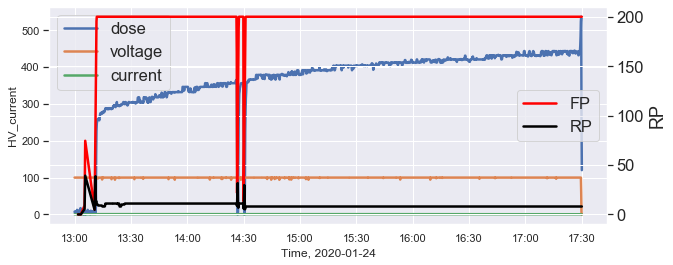

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y='dose_corrected', data=data, ax=ax,  label='dose')
sns.lineplot(x=data.index, y='HV_voltage', data=data, ax=ax,  label='voltage')
sns.lineplot(x=data.index, y='HV_current', data=data, ax=ax,  label='current')
ax2 = ax.twinx()
sns.lineplot(x=data.index, y='FP', data=data, ax=ax2, color='red', label='FP')
sns.lineplot(x=data.index, y='RP', data=data, ax=ax2,  color='black', label='RP')
# sns.lineplot(x=data.index, y='frequency', data=data, ax=ax,  label='frequency')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

ax.set_xlabel(f'Time, {DAY}')
plt.show()

## 2020-01-27

In [11]:
DAY = "2020-01-27"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-27.Suppression_without_extraction/'

In [12]:
# data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full = load_data_for_day_DATABASE(DAY, PATH)

In [13]:
data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full = load_data_for_day_CSV(DAY, PATH)

### Subset of the dataset

In [14]:
time_start = f"{DAY} 15:00:00"
time_end = f"{DAY} 19:15:00"


data_dose = data_dose.loc[time_start:time_end, :]
data_hv = data_hv.loc[time_start:time_end, :]
data_pressure = data_pressure.loc[time_start:time_end, :]
data_microwave_power_full = data_microwave_power_full.loc[time_start:time_end, :]
data_microwave_frequency_full = data_microwave_frequency_full.loc[time_start:time_end, :]


In [15]:
# data_microwave_power.loc["2020-01-24 13:29:00":"2020-01-24 13:35:00"]

In [16]:
d_hv = resample_30_seconds(data_hv, ['HV_current', 'HV_voltage'], time_start, time_end) 
d_dose = resample_30_seconds(data_dose, ['dose_corrected'], time_start, time_end)
d_mw_power = resample_30_seconds(data_microwave_power_full, ['power_setpoint', 'FP', 'RP'], time_start, time_end)
d_mw_freq = resample_30_seconds(data_microwave_frequency_full, ['frequency'], time_start, time_end)

data = pd.merge(d_hv, d_dose, left_index=True, right_index=True, how='outer') # dose is actually not needed
data = pd.merge(data, d_mw_power, left_index=True, right_index=True, how='outer') # dose is actually not needed
data = pd.merge(data, d_mw_freq, left_index=True, right_index=True, how='outer') # dose is actually not needed

dfs[DAY] = data

data.head()


,HV_current,HV_voltage,dose_corrected,power_setpoint,FP,RP,frequency
time,,,,,,,
2020-01-27 15:00:00,0.0,0.0,12.382925,NaN,NaN,NaN,NaN
2020-01-27 15:00:10,0.0,0.0,14.779620,NaN,NaN,NaN,NaN
2020-01-27 15:00:20,0.0,0.0,21.969705,NaN,NaN,NaN,NaN
2020-01-27 15:00:30,0.0,0.0,19.573010,NaN,NaN,NaN,NaN
2020-01-27 15:00:40,0.0,0.0,19.573010,NaN,NaN,NaN,NaN


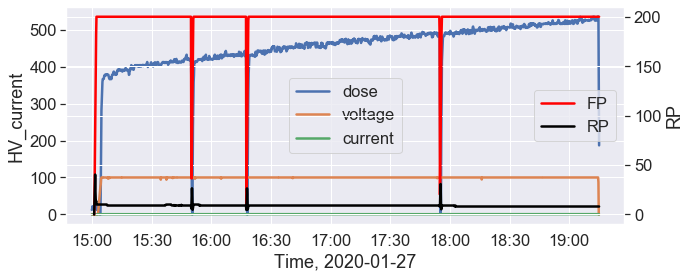

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y='dose_corrected', data=data, ax=ax,  label='dose')
sns.lineplot(x=data.index, y='HV_voltage', data=data, ax=ax,  label='voltage')
sns.lineplot(x=data.index, y='HV_current', data=data, ax=ax,  label='current')
ax2 = ax.twinx()
sns.lineplot(x=data.index, y='FP', data=data, ax=ax2, color='red', label='FP')
sns.lineplot(x=data.index, y='RP', data=data, ax=ax2,  color='black', label='RP')
# sns.lineplot(x=data.index, y='frequency', data=data, ax=ax,  label='frequency')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

ax.set_xlabel(f'Time, {DAY}')
plt.show()

## 2020-01-28

In [18]:
DAY = "2020-01-28"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-28.Suppression_without_extraction/'

In [19]:
# data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full = load_data_for_day_DATABASE(DAY, PATH)

In [20]:
data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full = load_data_for_day_CSV(DAY, PATH)

### Subset of the dataset

In [21]:
time_start = f"{DAY} 09:45:00"
time_end = f"{DAY} 19:30:00"


data_dose = data_dose.loc[time_start:time_end, :]
data_hv = data_hv.loc[time_start:time_end, :]
data_pressure = data_pressure.loc[time_start:time_end, :]
data_microwave_power_full = data_microwave_power_full.loc[time_start:time_end, :]
data_microwave_frequency_full = data_microwave_frequency_full.loc[time_start:time_end, :]


In [22]:
# data_microwave_power.loc["2020-01-24 13:29:00":"2020-01-24 13:35:00"]

In [23]:
d_hv = resample_30_seconds(data_hv, ['HV_current', 'HV_voltage'], time_start, time_end) 
d_dose = resample_30_seconds(data_dose, ['dose_corrected'], time_start, time_end)
d_mw_power = resample_30_seconds(data_microwave_power_full, ['power_setpoint', 'FP', 'RP'], time_start, time_end)
d_mw_freq = resample_30_seconds(data_microwave_frequency_full, ['frequency'], time_start, time_end)

data = pd.merge(d_hv, d_dose, left_index=True, right_index=True, how='outer') # dose is actually not needed
data = pd.merge(data, d_mw_power, left_index=True, right_index=True, how='outer') # dose is actually not needed
data = pd.merge(data, d_mw_freq, left_index=True, right_index=True, how='outer') # dose is actually not needed

dfs[DAY] = data
data.head()


,HV_current,HV_voltage,dose_corrected,power_setpoint,FP,RP,frequency
time,,,,,,,
2020-01-28 09:45:00,0.0,0.0,14.779620,NaN,NaN,NaN,NaN
2020-01-28 09:45:10,0.0,0.0,17.176315,NaN,NaN,NaN,NaN
2020-01-28 09:45:20,0.0,0.0,12.382924,NaN,NaN,NaN,NaN
2020-01-28 09:45:30,0.0,0.0,17.176315,NaN,NaN,NaN,NaN
2020-01-28 09:45:40,0.0,0.0,7.589534,NaN,NaN,NaN,NaN


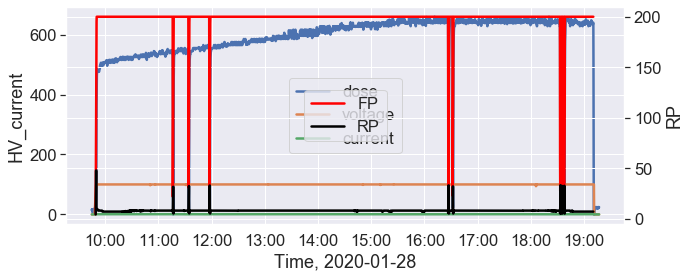

In [24]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y='dose_corrected', data=data, ax=ax,  label='dose')
sns.lineplot(x=data.index, y='HV_voltage', data=data, ax=ax,  label='voltage')
sns.lineplot(x=data.index, y='HV_current', data=data, ax=ax,  label='current')
ax2 = ax.twinx()
sns.lineplot(x=data.index, y='FP', data=data, ax=ax2, color='red', label='FP')
sns.lineplot(x=data.index, y='RP', data=data, ax=ax2,  color='black', label='RP')
# sns.lineplot(x=data.index, y='frequency', data=data, ax=ax,  label='frequency')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

ax.set_xlabel(f'Time, {DAY}')
plt.show()

### Collect all dataframes together

In [25]:
# Add some zeros before and after the operation, use middle one
day = '2020-01-27'
# how many periods to add
periods = 200

this_df = dfs[day]

# add at the end
range_start = this_df.index[-1]
s = pd.date_range(start=range_start, periods=periods, freq='10S')
df_out = pd.DataFrame(pd.Series(s[1:], name='time')).set_index('time')
num_cols = this_df.shape[1]
for ii in range(num_cols):
    df_out[ii] = 0
df_out.columns = this_df.columns
dfs[day] = pd.concat([this_df, df_out])

# add at the beginning
this_df = dfs[day]

range_start = this_df.index[0]
s = pd.date_range(start=range_start, periods=periods, freq='-10S')
df_out = pd.DataFrame(pd.Series(s[:-1], name='time')).set_index('time')
df_out = df_out.iloc[::-1]
num_cols = this_df.shape[1]
for ii in range(num_cols):
    df_out[ii] = -1
df_out.columns = this_df.columns
dfs[day] = pd.concat([df_out, this_df])

dfs[day]

,HV_current,HV_voltage,dose_corrected,power_setpoint,FP,RP,frequency
time,,,,,,,
2020-01-27 14:27:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-01-27 14:27:10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-01-27 14:27:20,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-01-27 14:27:30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-01-27 14:27:40,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...
2020-01-27 19:47:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27 19:47:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27 19:47:50,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data = pd.concat(dfs)
data.head()

HV_current  HV_voltage  dose_corrected  FP  \
           time                                                              
2020-01-24 2020-01-24 13:00:00    0.217043       100.0        7.589534 NaN   
           2020-01-24 13:00:10    0.217043       100.0        5.192839 NaN   
           2020-01-24 13:00:20    0.213913       100.0        5.192839 NaN   
           2020-01-24 13:00:30    0.214696       100.0        7.589534 NaN   
           2020-01-24 13:00:40    0.214696       100.0        7.589534 NaN   

                                RP  frequency  power_setpoint  
           time                                                
2020-01-24 2020-01-24 13:00:00 NaN        NaN             NaN  
           2020-01-24 13:00:10 NaN        NaN             NaN  
           2020-01-24 13:00:20 NaN        NaN             NaN  
           2020-01-24 13:00:30 NaN        NaN             NaN  
           2020-01-24 13:00:40 NaN        NaN             NaN

In [27]:
# compute the measurement time in each dataframe
def compute_measurement_time(data):
    idx =  data.index.get_level_values(1)
    data['time_delta_minutes'] = idx
    data['time_delta_minutes'] = data['time_delta_minutes'].apply(lambda x: (x - idx[0]).seconds/60)
    return data
data_meas_time = data.groupby(data.index.get_level_values(0)).apply(lambda x: compute_measurement_time(x))
data_meas_time = data_meas_time.reset_index(drop=True)
data_meas_time.head()

,HV_current,HV_voltage,dose_corrected,FP,RP,frequency,power_setpoint,time_delta_minutes
0,0.217043,100.0,7.589534,NaN,NaN,NaN,NaN,0.000000
1,0.217043,100.0,5.192839,NaN,NaN,NaN,NaN,0.166667
2,0.213913,100.0,5.192839,NaN,NaN,NaN,NaN,0.333333
3,0.214696,100.0,7.589534,NaN,NaN,NaN,NaN,0.500000
4,0.214696,100.0,7.589534,NaN,NaN,NaN,NaN,0.666667


In [28]:
# index where a new measurement started, ignore the first
idx_0 = data_meas_time[data_meas_time['time_delta_minutes'] == 0].index[1:]
# value before
idx_before = idx_0 - 1 

# for day 2, take the last value from day 1
t_last = data_meas_time.loc[idx_before[0], 'time_delta_minutes']
# for that index until the next, add the baseline
s = data_meas_time.loc[(data_meas_time.index >= idx_0[0]) & (data_meas_time.index < idx_0[1]),'time_delta_minutes']
s = s + t_last
data_meas_time.loc[(data_meas_time.index >= idx_0[0]) & (data_meas_time.index < idx_0[1]),'time_delta_minutes'] = s

# for day three, do the same
t_last = data_meas_time.loc[idx_before[1], 'time_delta_minutes']
# for that index until the next, add the baseline
s = data_meas_time.loc[(data_meas_time.index >= idx_0[1]),'time_delta_minutes']
s = s + t_last
data_meas_time.loc[(data_meas_time.index >= idx_0[1]),'time_delta_minutes'] = s


In [29]:
sns.reset_orig()

In [30]:

import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [31]:
OUTPUT_FOLDER = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/First_operation_WITH_suppression_without_extraction/'
FIGNAME = 'First_operation_WITH_suppression_without_extraction'

In [34]:
data = data_meas_time
data[data < 0] = np.nan
data.head()

,HV_current,HV_voltage,dose_corrected,FP,RP,frequency,power_setpoint,time_delta_minutes
0,0.217043,100.0,7.589534,NaN,NaN,NaN,NaN,0.000000
1,0.217043,100.0,5.192839,NaN,NaN,NaN,NaN,0.166667
2,0.213913,100.0,5.192839,NaN,NaN,NaN,NaN,0.333333
3,0.214696,100.0,7.589534,NaN,NaN,NaN,NaN,0.500000
4,0.214696,100.0,7.589534,NaN,NaN,NaN,NaN,0.666667


In [36]:
data_mcnp_LUT = pd.read_csv("/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/LUT_dose_output.csv", index_col=0) # output per 100 muSv/hr
# take 100 kV
dose_to_output = data_mcnp_LUT.loc[100, 'E']
dose_to_output = dose_to_output / 100 # per 1 muSv/h
data['output'] = data['dose_corrected'] * dose_to_output
dose_to_output # output per 1 muSv/hr
data.head()


,HV_current,HV_voltage,dose_corrected,FP,RP,frequency,power_setpoint,time_delta_minutes,output
0,0.217043,100.0,7.589534,NaN,NaN,NaN,NaN,0.000000,263505.154591
1,0.217043,100.0,5.192839,NaN,NaN,NaN,NaN,0.166667,180292.998500
2,0.213913,100.0,5.192839,NaN,NaN,NaN,NaN,0.333333,180292.998500
3,0.214696,100.0,7.589534,NaN,NaN,NaN,NaN,0.500000,263505.154591
4,0.214696,100.0,7.589534,NaN,NaN,NaN,NaN,0.666667,263505.154591


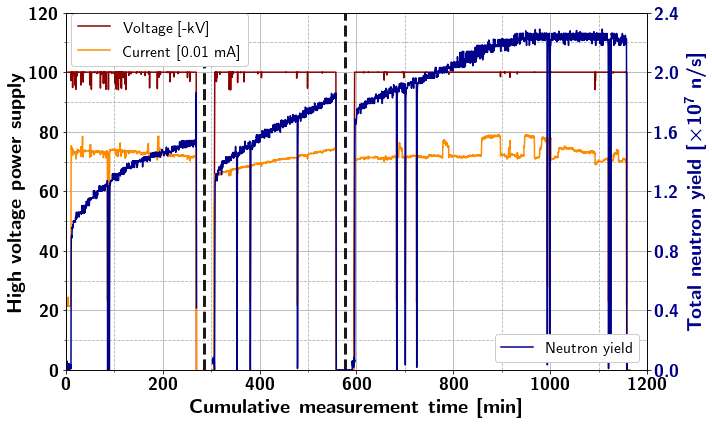

In [40]:
fig = plt.figure(figsize=(10,6))
fs = 20

plt.plot(data['time_delta_minutes'].values, data['HV_voltage'].values, label='Voltage [-kV]', color='darkred')
plt.plot(data['time_delta_minutes'].values, data['HV_current'].values * 100, label='Current [0.01 mA]', color='darkorange')
# first measurement change
t0 = data_meas_time.loc[idx_0, 'time_delta_minutes'].values[0]
offset = 16
plt.plot([t0+offset, t0+offset], [0, 120], '--k', linewidth=3)

# second measurement change
t0 = data_meas_time.loc[idx_0, 'time_delta_minutes'].values[1]
offset = -15
plt.plot([t0+offset, t0+offset], [0, 120], '--k', linewidth=3)
ax = plt.gca()

_ = plt.xlabel(r'\textbf{Cumulative measurement time [min]}',fontsize=fs)
_ = ax.set_ylabel(r'\textbf{High voltage power supply}', color='black',fontsize=fs)
_ = plt.legend(loc=(0.01, 0.85), fontsize=fs-4, framealpha=1)
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
# grid
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')


ax2 = ax.twinx()
# Turns off grid on the secondary (right) Axis.
ax2.grid(False)

ax2.set_ylabel(r"\textbf{Total neutron yield [$\times$10$^{7}$ n/s]}", color='darkblue',fontsize=fs)

ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=fs-2)
plt.plot(data['time_delta_minutes'].values, data['output'].values*1e-7, label='Neutron yield', color='darkblue')

_ = ax2.legend(loc="lower right", fontsize=fs-4, framealpha=1)
ax.set_ylim(0, 120)
ax.set_xlim(0, 1200)
ax2.set_ylim(0, 2.4)
ax2.set_yticks(np.arange(0, 2.4+0.2, 0.4))
plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/{FIGNAME}.pdf')
plt.show()

In [ ]:
data = data_meas_time
fig = plt.figure(figsize=(8,6))
fs = 20


plt.plot(data['time_delta_minutes'].values, data['FP'].values, label='FP', color='darkred')

ax = plt.gca()

_ = plt.xlabel(r'\textbf{Measurement time [min]}',fontsize=fs)
_ = ax.set_ylabel(r'\textbf{Forward power [W]}', color='black',fontsize=fs)
_ = plt.legend(loc=(0.01, 0.85), fontsize=fs-4)
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
# grid
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')


ax2 = ax.twinx()
# Turns off grid on the secondary (right) Axis.
ax2.grid(False)
ax2.set_ylabel(r"\textbf{Frequency}", color='darkblue',fontsize=fs)
ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=fs-2)

plt.plot(data['time_delta_minutes'].values, data['frequency'].values * 0.1, label='freq', color='darkblue')
_ = ax2.legend(loc="lower right", fontsize=fs-4, framealpha=1)
ax.set_ylim(190, 210)
ax.set_xlim(0, 1200)
ax2.set_ylim(2446, 2450)
# ax2.set_yticks(np.arange(0, 720+120, 120))
plt.tight_layout()
# plt.savefig(f'{OUTPUT_FOLDER}/{FIGNAME}.pdf')
plt.show()

In [ ]:
data['frequency'].describe()